Grupo x
- Lourenço Passeiro 20221838
- Miguel Marques 20221839
- Peter Lekszycki 20221840
- Tomás Gonçalves 20221894

## Imports

In [ ]:
import numpy as np
import random

import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from tqdm import trange
from copy import deepcopy
from scipy.stats import rankdata
import warnings

!pip install scikit-optimize
from skopt import gp_minimize
from skopt.space import Categorical, Real, Integer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 2.0 MB/s eta 0:00:00


# Geo Matrix

In [ ]:
def generate_matrix(seed, lower_bound, higher_bound):
    """
    Generate a matrix with random integer values within the specified bounds and enforce certain constraints.

    Args:
        seed (int): Seed value for random number generation to ensure reproducibility.
        lower_bound (int): Lower bound for random integer generation.
        higher_bound (int): Upper bound for random integer generation.

    Returns:
        list: A 10x10 matrix with random integer values between the specified bounds, where:
              - The value at matrix[2][1] is adjusted if it exceeds a threshold
              - Ensures there are more positive Geo earnings than negative ones
    """

    random.seed(seed)

    # generating values between the defined bounds
    matrix = [[random.randint(lower_bound, higher_bound) for _ in range(10)] for _ in range(10)]

    # we cannot go from one area to itself
    matrix = [['-' if i == j else matrix[i][j] for j in range(len(matrix))] for i in range(len(matrix))]

    # getting a list with the positive Geos
    geo_gains = [geo for area in matrix for geo in area if geo != '-' and geo > 0]

    # if the Geo from going G -> FC is 3.2% higher than the minimum positive Geo earning
    if matrix[2][1] > min(geo_gains) * 0.968:

        # we enforce it to be at least 3.2 % less than the minimum positive Geo gains.
        matrix[2][1] = round((random.uniform(lower_bound, 1-0.032) ) * min(geo_gains), 2)
        # if the new geo of going from G to FC happened to be lower than our lower bound, we winsorize it (make it equal to the lower bound)
        matrix[2][1] = max(matrix[2][1], lower_bound)

    # getting again a list with the positive Geos, with the updated values, and one with the negatives
    geo_gains = [geo for area in matrix for geo in area if geo != '-' and geo > 0]
    geo_losses = [geo for area in matrix for geo in area if geo != '-' and geo < 0]

    # if we do not have more positive than negative Geo earnings
    if len(geo_gains) <= len(geo_losses):

        # we generate another matrix, with the bounds shifted one unit to the right (to increase the probability of getting more positives)
        return generate_matrix(seed, lower_bound+1, higher_bound+1)

    else:
        return matrix

In [ ]:
matrix1 = generate_matrix(seed=random.random(), lower_bound=-100, higher_bound=100)
labels = ['D','FC','G','QS','QG','CS','KS','RG','DV','SN']
print('    '.join(label for label in labels))
for label, place in zip(labels, matrix1):
    print(label, place)

D    FC    G    QS    QG    CS    KS    RG    DV    SN
D ['-', 7, 82, 95, -82, -36, -94, -19, -37, -15]
FC [59, '-', -22, 13, 28, -63, -99, -100, 3, 64]
G [-74, -32.05, '-', 66, 40, -35, 91, 89, -50, 44]
QS [83, -31, -84, '-', -22, 19, 31, 57, -98, -83]
QG [-73, -61, 33, 79, '-', 94, 91, 75, -46, -24]
CS [74, -97, -70, 1, 11, '-', -30, 58, -47, 0]
KS [39, 88, -60, -88, 9, -95, '-', -33, 99, 59]
RG [41, 6, 82, 25, -34, 72, 84, '-', 99, -71]
DV [100, 16, 11, 45, 97, 60, -35, -74, '-', -8]
SN [-20, -52, 80, 33, -58, -78, 86, -12, 55, '-']


In [ ]:
area_codes = {label:i for i, label in enumerate(labels)}
area_codes

{'D': 0,
 'FC': 1,
 'G': 2,
 'QS': 3,
 'QG': 4,
 'CS': 5,
 'KS': 6,
 'RG': 7,
 'DV': 8,
 'SN': 9}

# Individuals

In [ ]:
def check_constraints(ind):
    """
    Check if the given individual satisfies the constraints of our problem.

    Args:
        ind (list): A list representing an individual solution, where each element represents a location.

    Returns:
        bool: True if all constraints are satisfied, False otherwise.
    """

    size = len(ind)

    # All sessions must begin and end at D (0)
    if ind[0] != 0 or ind[-1] != 0:
        return False

    # If we skipped KS (6), we had to had gone directly from QS (3) to DV (8), and only skip after that sequence
    elif '-' in ind and ( ind.index(3) != (ind.index(8) - 1) or ind.index('-') < ind.index(8) or 6 in ind):
        return False

    # We cannot go from QG (4) directly to CS (5)

    elif ind.index(4) == ( ind.index(5) - 1 ):
        return False

    # The RG (7) have to be in the last half

    elif ind.index(7) <= size // 2  :
        return False

    else:
        return True

In [ ]:
def generate_solution(ind_size=11):
    """
    Generates a random valid solution for our problem.

    Args:
        ind_size (int): The fixed size of each solution..

    Returns:
        list: A list representing a valid solution where each element represents a location.
    """

    trips = list( range(1, ind_size-1) )  # Possible places to go
    np.random.shuffle(trips)   # Shuffle the possible places to go, to get a random combination of them

    # Enforcing in the initialization that every session will start and end in D (0)
    sol =  [0] + trips + [0]

    # While we don't get a solution that don't violate any constraint, we generate another from scratch
    while not check_constraints(sol):
        sol = generate_solution()

    return sol

In [ ]:
sample_sol = generate_solution()
sample_sol

[0, 1, 8, 9, 5, 2, 4, 3, 6, 7, 0]

In [ ]:
def get_fitness(matrix):
    """
    Calculate the fitness of a solution based on a matrix of Geo earnings.

    Args:
        matrix (list): A matrix of Geo earnings.

    Returns:
        function: A function that calculates the fitness of a solution, ensuring it satisfies the specified constraints.
    """

    def get_fitness_inner(sol):
        """
        Calculate the fitness of a solution based on a given individual.

        Args:
            sol (list): An individual solution representing a sequence of areas.

        Returns:
            int: The fitness value of the solution.
        """

        if not check_constraints(sol):    # If the solution violates any of the constraints, it is assigned a very uncompetitive fitness
            return -1

        fitness = 0
        # Iterating from the second to the last element
        for i in range(1, len(sol)):
            if sol[i] != '-':        # If the current area was not skipped

                if sol[i-1] != '-':                         # And if the past area was not skipped
                    geo = matrix[sol[i-1]][sol[i]]              # We sum the geo of the trip to our fitness
                    if isinstance(geo, int):
                        fitness += geo

                else:                                       # And the past area was skipped
                    geo = matrix[sol[i-2]][sol[i]]              # We sum the geo of the trip (from the area before the
                                                                # skip to the area after it) to our fitness
                    if isinstance(geo, int):
                        fitness += geo
            else:
                continue              # If the current area was skipped, we skip this iteration since we don't have Geo to account for

        return fitness

    return get_fitness_inner

In [ ]:
get_fitness(matrix1)(sample_sol)

12

# Population

In [ ]:
def create_population(ind_size=11):
    """
    Create a population of individuals based on a matrix of Geo earnings and specified individual size.

    Args:
        ind_size (int): Size of the individual (default is 11, given our problem).

    Returns:
        function: A function that generates a population of individuals, ensuring they satisfy the specified constraints.
    """

    def generate_pop(pop_size):
        """
        Generate a population of individuals.

        Args:
            pop_size (int): Size of the population.

        Returns:
            list: A list of individuals, each represented as a sequence of areas.
        """

        return [generate_solution(ind_size) for _ in range(pop_size)]

    return generate_pop

In [ ]:
sample_pop = create_population()(10)
sample_pop

[[0, 1, 2, 9, 4, 8, 6, 5, 7, 3, 0],
 [0, 6, 5, 2, 9, 1, 4, 3, 7, 8, 0],
 [0, 3, 5, 4, 6, 1, 8, 7, 2, 9, 0],
 [0, 4, 2, 5, 1, 6, 3, 9, 8, 7, 0],
 [0, 3, 1, 5, 9, 2, 6, 4, 7, 8, 0],
 [0, 4, 2, 6, 8, 1, 9, 3, 5, 7, 0],
 [0, 3, 4, 2, 8, 1, 9, 5, 7, 6, 0],
 [0, 6, 1, 8, 2, 4, 3, 5, 7, 9, 0],
 [0, 9, 4, 6, 5, 1, 8, 2, 7, 3, 0],
 [0, 1, 3, 9, 6, 5, 7, 4, 8, 2, 0]]

In [ ]:
def evaluate_pop(matrix):
    """
    Evaluate the fitness of each individual in a population based on a matrix of Geo earnings.

    Args:
        matrix (list): A matrix of Geo earnings.

    Returns:
        function: A function that evaluates the fitness of each individual in a population.
    """

    def pop_evaluation(population):
        """
        Evaluate the fitness of each individual in a population. We also check if we have advantages
        skiping a location, giving certain conditions.

        Args:
            population (list): A list of individuals, each represented as a sequence of areas.

        Returns:
            list: A list of fitness values corresponding to each individual in the population.
        """
        # Checking if we gain by skipping King's Station
        for ind in population:

            # If the individual visited KS,
            if 6 in ind:

                # And it was after DV, that was accessed directly from QS,
                if ind.index(6) > ind.index(8) and ind.index(3) == (ind.index(8) - 1):

                    # We compute the fitness gained by skipping and not skipping KS
                    fit_skipping = matrix[ ind[ind.index(6) - 1] ][ ind[ ind.index(6) + 1 ] ]

                    fit_no_skipping = int(matrix[ ind[ind.index(6) - 1] ][ 6 ]) + int(matrix[ 6 ][ ind[ind.index(6) + 1] ])

                    # If we gain more Geos by skipping than not skipping, we skip it
                    if fit_skipping > fit_no_skipping:
                        ind[ind.index(6)] = '-'

        return [get_fitness(matrix)(ind) for ind in population]

    return pop_evaluation

In [ ]:
sample_fits = evaluate_pop(matrix1)(sample_pop)
sample_fits

[-39, 96, 339, -429, 455, 372, 239, 113, 37, -157]

# Selection Algorithms

Roulette Wheel:

In [ ]:
def roulette_wheel(population, fitnesses):
    """
    Perform selection using the roulette wheel method.

    Args:
        population (list): A list of individuals.
        fitnesses (list): A list of fitness values corresponding to each individual in the population.

    Returns:
        object: The selected individual from the population.
    """
    roulette_wheel.abbv = 'rw'

    # If we have geo losses in our fitnesses, we have to add a constant (the minimum fitness plus 1) to every element
    # (to turn them into positives) so that the logic of probabilities can be applied
    if min(fitnesses) < 0:
        min_fitnesses = abs(min(fitnesses)) + 1
        fitnesses = [fit + min_fitnesses for fit in fitnesses] # Adding the constant to every fitness

    # Generating a random number between 0 and the total sum of all fitnesses, that will serve as a "pointer" in the roulette
    pointer = np.random.uniform(0, sum(fitnesses))

    # Now, we sum one by one each fitness. The first fitness whose addition will make the cumulative sum bigger than the pointer,
    # will be selected since that means that the pointer is in his "window"
    cumulative_fit = 0

    for i, fit in enumerate(fitnesses):
        cumulative_fit += fit

        # If the cumulative sum is bigger or equal than the pointer, that means we arrived at "window" of the pointer
        if pointer <= cumulative_fit:
            return population[i] # Returning the selected individual, on whose window the pointer was

In [ ]:
roulette_wheel(sample_pop, sample_fits)

[0, 4, 2, 6, 8, 1, 9, 3, 5, 7, 0]

Ranking Selection:

In [ ]:
def ranking_selection(population, fitnesses):
    """
    Perform selection using the ranking selection method.

    Args:
        population (list): A list of individuals.
        fitnesses (list): A list of fitness values corresponding to each individual in the population.

    Returns:
        object: The selected individual from the population.
    """
    ranking_selection.abbv = 'rs'

    # Getting a a list that stores our fitnesses ranked
    ranks = [int(val) for val in rankdata(fitnesses)]
    total = sum(ranks)

    # Generating a random number between 0 and the total sum of all ranks, that will serve as a "pointer" in the roulette
    pointer = np.random.uniform(0, total)

    # Now, we sum one by one each rank. The first rank whose addition will make the cumulative sum bigger than the pointer,
    # will be selected since that means that the pointer is in his "window"
    cumulative_pos = 0

    for i, position in enumerate(ranks):
        cumulative_pos += position

        # If the cumulative sum is bigger or equal than the pointer, that means we arrived at "window" of the pointer
        if pointer <= cumulative_pos:
            return population[i]

Tournament Selection:

In [ ]:
def tournament_selection(ts):
    """
    Perform selection using the tournament selection method with a given tournament size.

    Args:
        ts (int): The size of the tournament.

    Returns:
        function: A function that performs tournament selection on a population.
    """

    def tournament_sec(population, fitnesses):
        """
        Perform tournament selection on a population.

        Args:
            population (list): A list of individuals.
            fitnesses (list): A list of fitness values corresponding to each individual in the population.

        Returns:
            object: The selected individual from the population.
        """
        tournament_sec.ts_value = ts  # Set ts as an attribute to later access on the parameter search
        tournament_sec.abbv = 'ts'

        # Selecting ts random indexes from the population
        pool = random.choices([i for i in range(len(population))], k=ts)

        # Getting the fitnesses of the selected indexes
        pool_fits = [fitnesses[i] for i in pool]

        # Getting the fittest selected individual
        best = np.argmax(pool_fits)

        return population[pool[best]]

    return tournament_sec

In [ ]:
tournament_selection(10)(sample_pop, sample_fits)

[0, 3, 1, 5, 9, 2, 6, 4, 7, 8, 0]

# Operators

## Crossovers

In [ ]:
def check_xover(p1, p2):
    """
    Check and replace any occurrence of skipped locations in both parents.

    This function checks if the parents skipped a location, and replaces it with
    a 6 (the only location allowed to skip, in our problem) if found.

    Args:
        p1 (list): The first parent.
        p2 (list): The second parent.

    Returns:
        tuple: A tuple containing the modified versions of both parents.
    """

    p1 = [6 if gene == '-' else gene for gene in p1]
    p2 = [6 if gene == '-' else gene for gene in p2]

    return p1, p2

Cyclic crossover:

In [ ]:
def cyclic_xover(p1, p2):
    """
    Perform cyclic crossover between two parents to produce offspring.

    Args:
        p1 (list): The first parent.
        p2 (list): The second parent.

    Returns:
        tuple: A tuple containing two offspring resulting from the cyclic crossover operation.
    """
    cyclic_xover.abbv = 'cx'

    # correcting if there are skips in only one parent
    p1, p2 = check_xover(p1, p2)

    size = len(p1)
    o1 = [0] + [-1] * (size-2) + [0]
    o2 = [0] + [-1] * (size-2) + [0]

    # Choosing the first position, whose value will be saved in start_idx
    start_idx = idx = np.random.randint(1, size-1)
    while True:
        # Assigning the values of the parents to their respective offsprings on that position
        o1[idx] = p1[idx]
        o2[idx] = p2[idx]

        # The next index will be the position on parent1 of the previous value of parent 2
        idx = p1.index(p2[idx])

        # If the new position is equal to the starting index, the cycle is closed,
        # and we break the loop

        if idx == start_idx:
            break

    # Filling the rest of the offsprings with their unlinked parents
    for i in range(size):
        if o1[i] == -1:
            o1[i] = p2[i]
        if o2[i] == -1:
            o2[i] = p1[i]

    return o1, o2

PMX Crossover:

In [ ]:
def pmx_xover(p1, p2):
    """
    Perform partially matched crossover (PMX) between two parents to produce offspring.

    Args:
        p1 (list): The first parent.
        p2 (list): The second parent.

    Returns:
        tuple: A tuple containing two offspring resulting from the PMX crossover operation.
    """
    pmx_xover.abbv = 'pmx'

    # correcting if there are skips in only one parent
    p1, p2 = check_xover(p1, p2)

    size = len(p1)
    # Selecting two crossover points
    xp1, xp2 = sorted(random.sample(range(1, size-1), 2))

    o1 = [0] + [-1] * (size - 2) + [0]
    o2 = [0] + [-1] * (size - 2) + [0]

    # Copying the crossover subset from the parents to their unlinked offsprings
    o1[xp1:xp2+1] = p2[xp1:xp2+1]
    o2[xp1:xp2+1] = p1[xp1:xp2+1]

    # Iterating over the copied range
    for i in range(xp1, xp2+1):
        # if the current parent gene is not on its offspring
        if p1[i] not in o1:
            # we store the position of the current gene of parent 2 on parent1
            idx = p1.index(p2[i])
            # if that position is not empty in the offspring
            while o1[idx] != -1:
                # we go to other position
                idx = p1.index(p2[idx])
            # fill the offspring on that position with the first position of parent 1
            o1[idx] = p1[i]

    # Doing it the same to offspring 2
        if p2[i] not in o2:
            idx = p2.index(p1[i])
            while o2[idx] != -1:
                idx = p2.index(p1[idx])
            o2[idx] = p2[i]

    # Filling the remaining spots with the genes from their parents
    for i in range(size):
        if o1[i] == -1:
            o1[i] = p1[i]
        if o2[i] == -1:
            o2[i] = p2[i]

    return o1, o2

In [ ]:
pmx_xover(sample_sol, sample_sol[::-1])

([0, 7, 6, 3, 4, 2, 5, 9, 8, 1, 0], [0, 1, 8, 9, 5, 2, 4, 3, 6, 7, 0])

Ordered Crossover:

In [ ]:
def ordered_xover(p1, p2):
    """
    Perform ordered crossover (OX) between two parents to produce offspring.

    Args:
        p1 (list): The first parent.
        p2 (list): The second parent.

    Returns:
        tuple: A tuple containing two offspring resulting from the ordered crossover operation.
    """
    ordered_xover.abbv = 'ox'

    # correcting if there are skips in only one parent
    p1, p2 = check_xover(p1, p2)

    size = len(p1)

    # Selecting two crossover points
    xp1, xp2 = sorted(random.sample(range(1, size-1), 2))

    o1 = [0] + [-1]*(size-2) + [0]
    o2 = [0] + [-1]*(size-2) + [0]

    # Copying the crossover subset from the parents to their unlinked offsprings
    o1[xp1:xp2+1] = p2[xp1:xp2+1]
    o2[xp1:xp2+1] = p1[xp1:xp2+1]

    # Getting a list with the unpasted areas of each parent to their offsprings
    p1_remaining = [gene for gene in p1[1:-1] if gene not in o1]
    p2_remaining = [gene for gene in p2[1:-1] if gene not in o2]

    # We start filling the offspring from the last xover point
    i = xp2+1
    # While there are still areas to fill
    while len(p1_remaining) != 0 and len(p2_remaining) != 0:

        # If we reach the end of our list (individual)
        if i == 11:
          # We go back to the beggining
            i = i % 11

        # If the current position of the offspring is unfilled
        if o1[i] == -1:
          # We fill with the first gene of the remaining from their parents (to preserve the order)
            o1[i] = p1_remaining[0]
            # And remove it from the positions remaining
            p1_remaining.remove(o1[i])

        # The same for the other offspring
        if o2[i] == -1:
            o2[i] = p2_remaining[0]
            p2_remaining.remove(o2[i])

        i += 1

    return o1, o2

In [ ]:
ordered_xover(sample_sol, sample_sol[::-1])

([0, 4, 3, 6, 7, 2, 5, 1, 8, 9, 0], [0, 5, 9, 8, 1, 2, 4, 7, 6, 3, 0])

Two-Point Crossover:

In [ ]:
def two_point_xover(p1, p2):
    """
    Perform two-point crossover between two parents to produce offspring.

    Args:
        p1 (list): The first parent.
        p2 (list): The second parent.

    Returns:
        tuple: A tuple containing two offspring resulting from the two-point crossover operation.
    """
    two_point_xover.abbv = 'tpx'

    # correcting if there are skips in only one parent
    p1, p2 = check_xover(p1, p2)

    # Choosing crossover points
    start, end = sorted(random.sample(range(1, len(p1)-1), 2))

    # Each offspring will have a subset of their unlinked parent
    o1 = p1[1:start] + p2[start:end] + p1[end:-1]
    o2 = p2[1:start] + p1[start:end] + p2[end:-1]


    # Storing the duplicates
    duplicated1 = list(set([value for value in o1 if o1.count(value) > 1]))
    duplicated2 = list(set([value for value in o2 if o2.count(value) > 1]))

    # Shuffling the order of the lists to guarantee randomness when exchanging the bits between the 2 offsprings
    random.shuffle(duplicated1)
    random.shuffle(duplicated2)

    # Swapping the duplicate values
    for val1, val2 in zip(duplicated1,duplicated2):
        o1[o1.index(val1)] = o2[o2.index(val2)]
        o2[o2.index(val2)] = o1[o1.index(val1)]

    return [0] + o1 + [0] , [0] + o2 + [0]

## Mutation

Swap mutation:

In [ ]:
def swap_mutation(ind, p_m):
    """
    Perform swap mutation on an individual with a given mutation probability.

    Args:
        ind (list): The individual to undergo mutation.
        p_m (float): The probability of mutation for each gene in the individual.

    Returns:
        list: The mutated individual.
    """
    swap_mutation.abbv = 'sm'

    size = len(ind)
    off = ind.copy()

    for i in range(1, size-3):
        if random.random() < p_m:
            j = random.randint(i+1, size-2)
            # Swapping the elements on them
            off[i], off[j] = off[j], off[i]

    return off

In [ ]:
print(sample_sol, swap_mutation(sample_sol, 1))

[0, 1, 8, 9, 5, 2, 4, 3, 6, 7, 0] [0, 9, 1, 6, 3, 8, 7, 4, 2, 5, 0]


Inversion mutation:

In [ ]:
def inversion_mutation(ind, p_m):
    """
    Perform inversion mutation on an individual with a given mutation probability.

    Args:
        ind (list): The individual to undergo mutation.
        p_m (float): The probability of mutation for each gene in the individual.

    Returns:
        list: The mutated individual.
    """
    inversion_mutation.abbv = 'im'

    size = len(ind)
    off = ind.copy()

    for i in range(1, size-3):
        if random.random() < p_m:
            # Selecting
            j = random.randint(i+1, size-2)
            #print(i, j)
            # Inverting the subset selected
            off = off[:i] + off[i:j+1][::-1] + off[j+1:]

    return off

In [ ]:
print(sample_sol, inversion_mutation(sample_sol, 0.2) )

[0, 1, 8, 9, 5, 2, 4, 3, 6, 7, 0] [0, 1, 8, 9, 5, 2, 4, 3, 6, 7, 0]


Mix mutation\:

In [ ]:
def mix_mutation(ind, p_m):
    """
    Perform mix mutation on an individual with a given mutation probability.

    Args:
        ind (list): The individual to undergo mutation.
        p_m (float): The probability of mutation for each gene in the individual.

    Returns:
        list: The mutated individual.
    """
    mix_mutation.abbv = 'mm'

    size = len(ind)
    off = ind.copy()

    for i in range(1, size-2):
        if random.random() < p_m:
            # Selecting
            j = random.randint(i+1, size-1)
            #print(i, j)
            # Selecting the subset between the chosen positions
            subset = off[i:j]
            random.shuffle(subset)
            off = off[:i] + subset + off[j:]


    return off

In [ ]:
print(sample_sol, mix_mutation(sample_sol, 0.2))

[0, 1, 8, 9, 5, 2, 4, 3, 6, 7, 0] [0, 1, 8, 9, 2, 5, 4, 6, 7, 3, 0]


Displacement Mutation:

In [ ]:
def disp_mutation(ind, p_m):
    """
    Perform displacement mutation on an individual with a given mutation probability.

    Args:
        ind (list): The individual to undergo mutation.
        p_m (float): The probability of mutation for each gene in the individual.

    Returns:
        list: The mutated individual.
    """
    disp_mutation.abbv = 'dm'

    size = len(ind)
    off = ind.copy()

    for i in range(1, size-2):
        if random.random() < p_m:
            j = random.randint(i+1, size-1)
            #print(i, j)
            # Selecting the subset between the chosen positions
            subset = off[i:j]
            # Updating the offspring to only get the elements that are not on the subset
            off = [gene for gene in off if gene not in subset]
            # Choosing a random index
            index = random.randint(-len(off) + 1, -(len(off)-1))
            #print(index)
            # Inserting the subset on our offspring on the index we got
            off[index:index] = subset

    return off

In [ ]:
print(sample_sol, disp_mutation(sample_sol, 1))

[0, 1, 8, 9, 5, 2, 4, 3, 6, 7, 0] [0, 6, 7, 8, 2, 1, 9, 5, 4, 3, 0]


Two-point Mutation:

In [ ]:
def two_point_mutation(ind, p_m):
    """
    Perform two-point mutation on an individual with a given mutation probability.

    Args:
        ind (list): The individual to undergo mutation.
        p_m (float): The probability of mutation for each gene in the individual.

    Returns:
        list: The mutated individual.
    """
    two_point_mutation.abbv = 'tpm'

    size = len(ind)
    off = ind.copy()

    # Iterating over the individual positions
    for i in range(1, size - 5):
        if random.random() < p_m:
            # Selecting one subset of length two from our index
            seq1 = ind[i:i + 2]
            j = random.randint(i + 2, size - 3)
            seq2 = ind[j:j + 2]  # Subsequence 'b' to be swapped

            off[i:i + 2], off[j:j + 2] = off[j:j + 2], off[i:i + 2]

    return off

# Elitism

In [ ]:
def get_n_elites(n):
    """
    Create a function to retrieve the top `n` elites from a population based on their fitness.

    Args:
        n (int): Number of elites to select.

    Returns:
        function: A function that retrieves the top `n` elites from a population and their corresponding fitness values.
    """

    def get_elite(population, pop_fit):
        """
        Retrieve the top 'n' elites from a population based on their fitness.

        Args:
            population (list): List of individuals in the population.
            pop_fit (list): List of fitness values corresponding to the individuals in the population.

        Returns:
            tuple: A tuple containing two lists:
                - List of top 'n' elite individuals.
                - List of fitness values corresponding to the top 'n' elite individuals.
        """

        # Getting the indexes of our n best elements, to return them
        elites_i = np.argsort(pop_fit)[-n:]

        return [population[i] for i in elites_i], [pop_fit[i] for i in elites_i]

    return get_elite

# Algorithm

In [ ]:
def GA(matrix, initializer, evaluator, selector, crossover, mutator, elite_func,
       pop_size, n_gens, p_xo, p_m, verbose=False,
       log_path=None, elitism=True, seed=0):
    """
    Perform a Genetic Algorithm (GA) optimization.

    Args:
        matrix (list): A matrix of Geo earnings.
        initializer (function): A function to initialize the population.
        evaluator (function): A function to evaluate the fitness of individuals in the population.
        selector (function): A function to select individuals from the population.
        crossover (function): A function to perform crossover between selected individuals.
        mutator (function): A function to mutate individuals in the population.
        elite_func (function): A function to select elite individuals from the population.
        pop_size (int): Size of the population.
        n_gens (int): Number of generations.
        p_xo (float): Probability of crossover.
        p_m (float): Probability of mutation.
        verbose (bool, optional): Whether to print verbose output (default is False).
        log_path (str, optional): Path to the log file (default is None).
        elitism (bool, optional): Whether to use elitism (default is True).
        seed (int, optional): Seed for random number generation (default is 0).

    Returns:
        tuple: A tuple containing the final population and their fitness values.
    """

    # Setting the seed
    random.seed(seed)

    if elite_func is None:
        raise Exception('elite_func cannot be None')

    # Initializing our population
    population = initializer()(pop_size)

    # Evaluating it
    pop_fit = evaluator(matrix)(population)

    # Initiating our generations
    for gen in range(1, n_gens):

        offspring = []

        # While our offsprings are not of the size of our population, we select two parents to input there
        while len(offspring) < pop_size:
            p1, p2 = selector(population, pop_fit), selector(population, pop_fit)

            # xover or reproduction
            if random.random() < p_xo:
                # do xover
                o1, o2 = crossover(p1,p2)

            else:
                # do reproduc
                o1, o2 = deepcopy(p1), deepcopy(p2)

            o1, o2 = mutator(o1, p_m), mutator(o2,p_m)

            offspring.extend([o1, o2])

        # While our offsprings are longer than the population, we pop the last individual out
        while len(offspring) > pop_size:
            offspring.pop()

        if elitism:
            offspring[- len(elite_func(population, pop_fit)[0]):], best_fits = elite_func(population, pop_fit)

        # Our offsprings turns into our population
        population = offspring
        pop_fit = evaluator(matrix)(population)

        new_elite, new_fit = elite_func(population, pop_fit)[0][-1], elite_func(population, pop_fit)[1][-1]

        if verbose:
                print(f' {gen} | {new_fit} ')
                print('-' * 32)

        if log_path is not None:
             with open(log_path, 'a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([seed, gen, new_fit, new_elite])


    return population, pop_fit

# Main

## Test

In [ ]:
# Our geo matrices
matrix1 = generate_matrix(seed=1, lower_bound=-9, higher_bound=11)
matrix2 = generate_matrix(seed=2, lower_bound=-30, higher_bound=70)
matrix3 = generate_matrix(seed=3, lower_bound=-10, higher_bound=90)
matrix4 = generate_matrix(seed=4, lower_bound=-98, higher_bound=102)
matrix5 = generate_matrix(seed=5, lower_bound=-300, higher_bound=700)
matrix6 = generate_matrix(seed=6, lower_bound=-100, higher_bound=900)
matrix7 = generate_matrix(seed=7, lower_bound=-980, higher_bound=1020)
matrix8 = generate_matrix(seed=8, lower_bound=-3000, higher_bound=7000)
matrix9 = generate_matrix(seed=9, lower_bound=-1000, higher_bound=9000)
matrix10 = generate_matrix(seed=10, lower_bound=-9800, higher_bound=10200)
matrix11 = generate_matrix(seed=11, lower_bound=-30000, higher_bound=70000)
matrix12 = generate_matrix(seed=12, lower_bound=-10000, higher_bound=90000)
matrix13 = generate_matrix(seed=13, lower_bound=-98000, higher_bound=102000)
matrix14 = generate_matrix(seed=14, lower_bound=-300000, higher_bound=700000)
matrix15 = generate_matrix(seed=17, lower_bound=-100000, higher_bound=900000)
matrix16 = generate_matrix(seed=18, lower_bound=-980000, higher_bound=1020000)
matrix17 = generate_matrix(seed=19, lower_bound=-3000000, higher_bound=7000000)
matrix18 = generate_matrix(seed=20, lower_bound=-1000000, higher_bound=9000000)

In [ ]:
# function based parameters
matrix = [matrix1, matrix2, matrix3, matrix4, matrix5, matrix6, matrix7, matrix8, matrix9, matrix10, matrix11, matrix12, matrix13, matrix14, matrix15, matrix16, matrix17, matrix18]
selectors = [roulette_wheel, ranking_selection, tournament_selection(10)]
crossovers = [cyclic_xover, pmx_xover, ordered_xover, two_point_xover]
mutators = [swap_mutation, inversion_mutation, mix_mutation, disp_mutation, two_point_mutation]

initializer = create_population

evaluator = evaluate_pop

selector = random.choice(selectors)

xover = random.choice(crossovers)
mutator = random.choice(mutators)

# evolution based parameters

pop_size = 50

n_gens = 300

p_xo = 0.7

p_m = 0.3

n_elites = 3

for seed in trange(10):
    GA(matrix=matrix1,
       initializer=initializer,
       evaluator=evaluator,
       selector=selector,
       crossover= xover,
       mutator=mutator,
       pop_size=pop_size,
       n_gens=n_gens,
       p_xo=p_xo,
       p_m=p_m,
       verbose=False, log_path=None,
       elitism=False, elite_func=get_n_elites(n_elites), seed=seed)

100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


In [ ]:
results = pd.read_csv('sample_data/test_log.csv', index_col=1)  # 5000 = 10 seeds * 500gens
results.reset_index(inplace=True)
results.columns = ['gen','iter', 'fittest_ind', 'individual']
results

#Results

## Bayesian Search

Running the search:

In [ ]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="The objective has been evaluated at point", category=UserWarning)

# Defining the parameter mapping
param_mapping = {
    "selector": [roulette_wheel, ranking_selection, tournament_selection(2), tournament_selection(5), tournament_selection(10)],
    "crossover": [cyclic_xover, pmx_xover, ordered_xover, two_point_xover],
    "mutator": [swap_mutation, inversion_mutation, mix_mutation, disp_mutation, two_point_mutation],
    "elitism": [True, False] }

# Also defining an wrapper function of our algorithm, to be able to input it into the Bayesian Optimization
def genetic_algorithm_wrapper(matrix, selector, crossover, mutator, pop_size, n_gens, p_xo, p_m, elitism, n_elites):
    """
    A wrapper function for running a genetic algorithm with specified parameters.

    This function initializes the population, evaluates it, and iterates over a number of generations
    to evolve solutions based on selection, crossover, mutation, and elitism strategies.

    Args:
        The same as the GA() function.

    Returns:
        float: The negation of the fitness of the best individual in the final population,
               suitable for use with optimization algorithms that minimize the objective.
    """

    initializer = create_population
    evaluator = evaluate_pop
    elite_func = get_n_elites(n_elites)

    selector = param_mapping["selector"][selector]
    crossover = param_mapping["crossover"][crossover]
    mutator = param_mapping["mutator"][mutator]
    elitism = param_mapping["elitism"][elitism]

    # Call GA function with the parameters defining above
    _, pop_fit = GA(matrix, initializer, evaluator, selector, crossover, mutator, elite_func,
                    pop_size, n_gens, p_xo, p_m, elitism=elitism)

    # Returning the negation of our best individual, since gp_minimize works assumes this is a minimization problem
    return -max(pop_fit)

# Defining the search space for Bayesian optimization
space = [
    Categorical(list(range(len(param_mapping["selector"]))), name='selector'),
    Categorical(list(range(len(param_mapping["crossover"]))), name='crossover'),
    Categorical(list(range(len(param_mapping["mutator"]))), name='mutator'),
    Categorical(categories=[25, 50, 100], name='pop_size'),
    Categorical(categories=[250, 500, 750], name='n_gens'),
    Categorical(categories=[0.2, 0.4, 0.6, 0.8], name='p_xo'),
    Categorical(categories=[0.2, 0.4, 0.6, 0.8], name='p_m'),
    Categorical(categories=[True, False], name='elitism'),
    Categorical(categories=[2, 3, 4, 5], name='n_elites'),
]

# Defining a dict to store our results
results = {}

# Iterating over every matrix
for i, mat in enumerate([matrix1, matrix2, matrix3, matrix4, matrix5, matrix6, matrix7, matrix8, matrix9, matrix10, matrix11, matrix12, matrix13, matrix14, matrix15, matrix16, matrix17, matrix18]):
    # Defining a dict to store the results of each matrix
    results_mat = []
    # Performing the parameter search 10 times, for each matrix
    for _ in trange(10):

        result = gp_minimize(
            lambda params: genetic_algorithm_wrapper(mat, *params),  # our objective function that will be minimized
            space,                      # our search space
            n_calls=15,                 # the number of evaluations of the objective function
            random_state=24,            # random seed for reproducibility
        )

        # Getting our results  in a more pretty way
        res = [param_mapping[par][result.x[i]].__name__ + (str(param_mapping[par][result.x[i]].ts_value) if 'tournament' in str(param_mapping[par][result.x[i]]) else '')
               for i, par in enumerate(['selector', 'crossover', 'mutator']) ]

        res.extend(result.x[3:])
        print(res, -result.fun)

        results_mat.append([res, -result.fun])   # Negating again our results, to cancel the negation on the wrapper function
    print(f"{i+1}")

    results[f'Matrix{i+1}'] = results_mat

 10%|█         | 1/10 [00:13<02:05, 13.96s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 87


 20%|██        | 2/10 [00:36<02:31, 18.99s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 87


 30%|███       | 3/10 [00:51<01:59, 17.01s/it]

['roulette_wheel', 'pmx_xover', 'mix_mutation', 25, 750, 0.2, 0.8, False, 3] 87


 40%|████      | 4/10 [01:12<01:52, 18.67s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 87


 50%|█████     | 5/10 [01:30<01:31, 18.32s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 87


 60%|██████    | 6/10 [01:47<01:12, 18.15s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 87


 70%|███████   | 7/10 [02:04<00:52, 17.61s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 87


 80%|████████  | 8/10 [02:26<00:37, 18.93s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 87


 90%|█████████ | 9/10 [02:42<00:18, 18.19s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 87


100%|██████████| 10/10 [02:57<00:00, 17.77s/it]


['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 87
1


 10%|█         | 1/10 [00:13<02:05, 13.90s/it]

['tournament_sec10', 'two_point_xover', 'swap_mutation', 25, 750, 0.8, 0.2, False, 2] 533


 20%|██        | 2/10 [00:29<02:00, 15.05s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 533


 30%|███       | 3/10 [00:46<01:50, 15.76s/it]

['tournament_sec5', 'two_point_xover', 'inversion_mutation', 50, 750, 0.4, 0.4, False, 2] 533


 40%|████      | 4/10 [01:02<01:34, 15.80s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 533


 50%|█████     | 5/10 [01:24<01:30, 18.15s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 533


 60%|██████    | 6/10 [01:40<01:09, 17.36s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 533


 70%|███████   | 7/10 [01:59<00:53, 17.85s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 533


 80%|████████  | 8/10 [02:15<00:34, 17.31s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 533


 90%|█████████ | 9/10 [02:32<00:17, 17.20s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 533


100%|██████████| 10/10 [02:50<00:00, 17.04s/it]


['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 533
2


 10%|█         | 1/10 [00:20<03:04, 20.49s/it]

['tournament_sec5', 'two_point_xover', 'inversion_mutation', 100, 750, 0.6, 0.6, False, 2] 763


 20%|██        | 2/10 [00:38<02:32, 19.05s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 763


 30%|███       | 3/10 [01:01<02:24, 20.64s/it]

['ranking_selection', 'cyclic_xover', 'swap_mutation', 100, 500, 0.6, 0.2, False, 4] 763


 40%|████      | 4/10 [01:20<02:00, 20.03s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 763


 50%|█████     | 5/10 [01:35<01:31, 18.26s/it]

['tournament_sec2', 'two_point_xover', 'inversion_mutation', 50, 250, 0.6, 0.2, False, 2] 763


 60%|██████    | 6/10 [01:54<01:14, 18.53s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 763


 70%|███████   | 7/10 [02:11<00:54, 18.10s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 763


 80%|████████  | 8/10 [02:34<00:39, 19.78s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 763


 90%|█████████ | 9/10 [02:52<00:19, 19.11s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 763


100%|██████████| 10/10 [03:10<00:00, 19.06s/it]


['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 763
3


 10%|█         | 1/10 [00:17<02:35, 17.26s/it]

['tournament_sec5', 'pmx_xover', 'inversion_mutation', 50, 750, 0.4, 0.2, False, 3] 763


 20%|██        | 2/10 [00:33<02:15, 16.88s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 250, 0.4, 0.4, False, 5] 763


 30%|███       | 3/10 [00:52<02:03, 17.59s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 763


 40%|████      | 4/10 [01:07<01:39, 16.64s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 759


 50%|█████     | 5/10 [01:26<01:28, 17.63s/it]

['tournament_sec5', 'two_point_xover', 'swap_mutation', 50, 750, 0.4, 0.2, False, 3] 763


 60%|██████    | 6/10 [01:52<01:21, 20.27s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 763


 70%|███████   | 7/10 [02:08<00:56, 18.90s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 763


 80%|████████  | 8/10 [02:24<00:35, 17.99s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 763


 90%|█████████ | 9/10 [02:40<00:17, 17.37s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 759


100%|██████████| 10/10 [03:04<00:00, 18.45s/it]


['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 763
4


 10%|█         | 1/10 [00:16<02:27, 16.37s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 5783


 20%|██        | 2/10 [00:32<02:09, 16.19s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 5783


 30%|███       | 3/10 [00:49<01:56, 16.58s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 5783


 40%|████      | 4/10 [01:17<02:05, 21.00s/it]

['tournament_sec5', 'two_point_xover', 'swap_mutation', 50, 750, 0.4, 0.2, False, 3] 5783


 50%|█████     | 5/10 [01:36<01:41, 20.34s/it]

['ranking_selection', 'pmx_xover', 'disp_mutation', 50, 250, 0.4, 0.4, False, 5] 5783


 60%|██████    | 6/10 [01:58<01:23, 20.93s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 5783


 70%|███████   | 7/10 [02:15<00:58, 19.66s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 5783


 80%|████████  | 8/10 [02:35<00:39, 19.63s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 5783


 90%|█████████ | 9/10 [02:53<00:19, 19.18s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 5685


100%|██████████| 10/10 [03:12<00:00, 19.28s/it]


['tournament_sec5', 'two_point_xover', 'disp_mutation', 25, 750, 0.6, 0.4, False, 4] 5783
5


 10%|█         | 1/10 [00:19<02:59, 19.92s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 7369


 20%|██        | 2/10 [00:54<03:50, 28.76s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 7369


 30%|███       | 3/10 [01:16<02:57, 25.34s/it]

['tournament_sec5', 'two_point_xover', 'swap_mutation', 50, 750, 0.4, 0.2, False, 3] 7369


 40%|████      | 4/10 [01:38<02:25, 24.19s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 7369


 50%|█████     | 5/10 [02:01<01:57, 23.58s/it]

['tournament_sec5', 'two_point_xover', 'swap_mutation', 50, 750, 0.4, 0.2, False, 3] 7369


 60%|██████    | 6/10 [02:37<01:51, 27.80s/it]

['tournament_sec5', 'two_point_xover', 'swap_mutation', 50, 750, 0.4, 0.2, False, 3] 7369


 70%|███████   | 7/10 [02:55<01:13, 24.65s/it]

['tournament_sec5', 'two_point_xover', 'swap_mutation', 50, 750, 0.4, 0.2, False, 3] 7369


 80%|████████  | 8/10 [03:12<00:44, 22.32s/it]

['tournament_sec10', 'two_point_xover', 'swap_mutation', 25, 500, 0.8, 0.2, False, 3] 7369


 90%|█████████ | 9/10 [03:47<00:26, 26.11s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 7369


100%|██████████| 10/10 [04:30<00:00, 27.08s/it]


['ranking_selection', 'cyclic_xover', 'inversion_mutation', 50, 250, 0.2, 0.4, False, 3] 7369
6


 10%|█         | 1/10 [00:31<04:40, 31.11s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 7959


 20%|██        | 2/10 [00:48<03:04, 23.06s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 7959


 30%|███       | 3/10 [01:04<02:18, 19.82s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 7959


 40%|████      | 4/10 [01:21<01:52, 18.75s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 7959


 50%|█████     | 5/10 [01:41<01:36, 19.24s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 7959


 60%|██████    | 6/10 [02:07<01:25, 21.40s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 7959


 70%|███████   | 7/10 [02:20<00:56, 18.78s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 7959


 80%|████████  | 8/10 [02:37<00:36, 18.09s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 7959


 90%|█████████ | 9/10 [02:54<00:17, 17.81s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 7959


100%|██████████| 10/10 [03:09<00:00, 18.96s/it]


['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 7959
7


 10%|█         | 1/10 [00:23<03:34, 23.81s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 46869


 20%|██        | 2/10 [00:43<02:50, 21.35s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 46869


 30%|███       | 3/10 [00:58<02:09, 18.50s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 46869


 40%|████      | 4/10 [01:19<01:55, 19.29s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 46869


 50%|█████     | 5/10 [01:37<01:35, 19.03s/it]

['tournament_sec5', 'cyclic_xover', 'swap_mutation', 50, 750, 0.6, 0.2, False, 3] 46869


 60%|██████    | 6/10 [01:57<01:16, 19.20s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 46869


 70%|███████   | 7/10 [02:12<00:54, 18.06s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 46869


 80%|████████  | 8/10 [02:26<00:33, 16.70s/it]

['tournament_sec5', 'pmx_xover', 'inversion_mutation', 50, 750, 0.4, 0.2, False, 3] 46869


 90%|█████████ | 9/10 [02:40<00:15, 15.90s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 46817


100%|██████████| 10/10 [03:03<00:00, 18.32s/it]


['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 46869
8


 10%|█         | 1/10 [00:23<03:29, 23.25s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 72044


 20%|██        | 2/10 [00:40<02:37, 19.69s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 72044


 30%|███       | 3/10 [00:58<02:12, 18.95s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 72044


 40%|████      | 4/10 [01:21<02:02, 20.44s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 72044


 50%|█████     | 5/10 [01:36<01:33, 18.63s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 72044


 60%|██████    | 6/10 [01:51<01:09, 17.38s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 72044


 70%|███████   | 7/10 [02:07<00:50, 16.85s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 72044


 80%|████████  | 8/10 [02:20<00:31, 15.74s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 72044


 90%|█████████ | 9/10 [02:39<00:16, 16.79s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 72044


100%|██████████| 10/10 [02:53<00:00, 17.39s/it]


['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 72044
9


 10%|█         | 1/10 [00:13<02:05, 13.90s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 62929


 20%|██        | 2/10 [00:34<02:22, 17.76s/it]

['tournament_sec2', 'two_point_xover', 'swap_mutation', 50, 750, 0.6, 0.2, False, 3] 62929


 30%|███       | 3/10 [00:48<01:53, 16.16s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 62929


 40%|████      | 4/10 [01:06<01:40, 16.80s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 62929


 50%|█████     | 5/10 [01:22<01:22, 16.43s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 62929


 60%|██████    | 6/10 [01:41<01:09, 17.30s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 62929


 70%|███████   | 7/10 [01:57<00:50, 16.94s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 62929


 80%|████████  | 8/10 [02:16<00:35, 17.68s/it]

['tournament_sec10', 'two_point_xover', 'swap_mutation', 25, 500, 0.8, 0.2, False, 3] 62929


 90%|█████████ | 9/10 [02:38<00:19, 19.11s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 62929


100%|██████████| 10/10 [02:57<00:00, 17.72s/it]


['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 62899
10


 10%|█         | 1/10 [00:16<02:32, 16.96s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 516715


 20%|██        | 2/10 [00:34<02:16, 17.02s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 516715


 30%|███       | 3/10 [00:53<02:07, 18.28s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 516715


 40%|████      | 4/10 [01:12<01:50, 18.37s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 516715


 50%|█████     | 5/10 [01:29<01:29, 17.86s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 516715


 60%|██████    | 6/10 [01:43<01:06, 16.65s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 516715


 70%|███████   | 7/10 [01:59<00:49, 16.41s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 516715


 80%|████████  | 8/10 [02:21<00:36, 18.16s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 516715


 90%|█████████ | 9/10 [02:43<00:19, 19.26s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 516715


100%|██████████| 10/10 [03:01<00:00, 18.12s/it]


['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 516715
11


 10%|█         | 1/10 [00:15<02:23, 15.90s/it]

['tournament_sec5', 'two_point_xover', 'swap_mutation', 50, 750, 0.4, 0.2, False, 3] 725468


 20%|██        | 2/10 [00:33<02:14, 16.81s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 725468


 30%|███       | 3/10 [00:52<02:05, 17.93s/it]

['tournament_sec5', 'two_point_xover', 'swap_mutation', 50, 750, 0.4, 0.2, False, 3] 725468


 40%|████      | 4/10 [01:07<01:39, 16.65s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 725468


 50%|█████     | 5/10 [01:34<01:42, 20.56s/it]

['ranking_selection', 'cyclic_xover', 'disp_mutation', 100, 500, 0.8, 0.4, False, 3] 725468


 60%|██████    | 6/10 [01:52<01:18, 19.61s/it]

['tournament_sec5', 'two_point_xover', 'swap_mutation', 50, 750, 0.4, 0.2, False, 3] 725468


 70%|███████   | 7/10 [02:27<01:13, 24.59s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 725468


 80%|████████  | 8/10 [03:22<01:08, 34.42s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 725468


 90%|█████████ | 9/10 [04:16<00:40, 40.56s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 725468


100%|██████████| 10/10 [05:11<00:00, 31.19s/it]


['tournament_sec5', 'two_point_xover', 'disp_mutation', 50, 750, 0.2, 0.4, False, 3] 725468
12


 10%|█         | 1/10 [01:15<11:22, 75.79s/it]

['tournament_sec5', 'two_point_xover', 'swap_mutation', 50, 750, 0.4, 0.2, False, 3] 731619


 20%|██        | 2/10 [02:17<08:59, 67.39s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 731619


 30%|███       | 3/10 [03:06<06:53, 59.12s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 731619


 40%|████      | 4/10 [03:58<05:36, 56.16s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 731619


 50%|█████     | 5/10 [05:31<05:47, 69.55s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 731619


 60%|██████    | 6/10 [06:18<04:07, 61.93s/it]

['tournament_sec5', 'two_point_xover', 'swap_mutation', 50, 750, 0.4, 0.2, False, 3] 731619


 70%|███████   | 7/10 [07:15<03:00, 60.25s/it]

['tournament_sec5', 'two_point_xover', 'swap_mutation', 50, 750, 0.4, 0.2, False, 3] 731619


 80%|████████  | 8/10 [08:09<01:56, 58.31s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 731619


 90%|█████████ | 9/10 [09:15<01:00, 60.73s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 731619


100%|██████████| 10/10 [10:13<00:00, 61.34s/it]


['tournament_sec5', 'two_point_xover', 'swap_mutation', 50, 750, 0.4, 0.2, False, 3] 731619
13


 10%|█         | 1/10 [00:56<08:29, 56.57s/it]

['tournament_sec2', 'cyclic_xover', 'mix_mutation', 50, 750, 0.4, 0.6, False, 3] 5076198


 20%|██        | 2/10 [01:47<07:06, 53.30s/it]

['tournament_sec5', 'pmx_xover', 'inversion_mutation', 50, 750, 0.4, 0.4, False, 5] 5076198


 30%|███       | 3/10 [02:38<06:04, 52.08s/it]

['roulette_wheel', 'pmx_xover', 'mix_mutation', 50, 500, 0.6, 0.2, False, 3] 5076198


 40%|████      | 4/10 [03:23<04:55, 49.28s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 5076198


 50%|█████     | 5/10 [04:16<04:13, 50.76s/it]

['tournament_sec5', 'two_point_xover', 'disp_mutation', 25, 750, 0.6, 0.6, False, 4] 5076198


 60%|██████    | 6/10 [05:59<04:33, 68.48s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 750, 0.2, 0.4, False, 3] 5076198


 70%|███████   | 7/10 [06:56<03:13, 64.63s/it]

['tournament_sec5', 'two_point_xover', 'swap_mutation', 50, 750, 0.4, 0.2, False, 3] 5076198


 80%|████████  | 8/10 [08:18<02:20, 70.23s/it]

['tournament_sec10', 'two_point_xover', 'swap_mutation', 25, 500, 0.8, 0.2, False, 3] 5076198


 90%|█████████ | 9/10 [09:27<01:09, 69.86s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 5076198


100%|██████████| 10/10 [10:23<00:00, 62.36s/it]


['tournament_sec5', 'two_point_xover', 'disp_mutation', 100, 250, 0.2, 0.6, False, 2] 5076198
14


 10%|█         | 1/10 [01:14<11:11, 74.61s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 7280064


 20%|██        | 2/10 [02:03<07:54, 59.32s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 7280064


 30%|███       | 3/10 [03:07<07:10, 61.54s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 7280064


 40%|████      | 4/10 [04:09<06:10, 61.74s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 7280064


 50%|█████     | 5/10 [04:56<04:42, 56.45s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 7280064


 60%|██████    | 6/10 [06:07<04:05, 61.49s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 7280064


 70%|███████   | 7/10 [07:02<02:57, 59.31s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 7280064


 80%|████████  | 8/10 [07:52<01:52, 56.35s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 7280064


 90%|█████████ | 9/10 [08:44<00:55, 55.02s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 7280064


100%|██████████| 10/10 [09:43<00:00, 58.31s/it]


['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 7280064
15


 10%|█         | 1/10 [00:51<07:46, 51.83s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 7344888


 20%|██        | 2/10 [01:56<07:53, 59.14s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 7344888


 30%|███       | 3/10 [02:47<06:29, 55.57s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 7344888


 40%|████      | 4/10 [03:37<05:21, 53.55s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 7344888


 50%|█████     | 5/10 [04:31<04:28, 53.72s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 7344888


 60%|██████    | 6/10 [05:49<04:07, 61.79s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 7344888


 70%|███████   | 7/10 [06:42<02:57, 59.05s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 7344888


 80%|████████  | 8/10 [07:42<01:58, 59.16s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 7344888


 90%|█████████ | 9/10 [08:30<00:55, 55.92s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 7344888


100%|██████████| 10/10 [08:55<00:00, 53.59s/it]


['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 7344888
16


 10%|█         | 1/10 [00:24<03:40, 24.48s/it]

['roulette_wheel', 'cyclic_xover', 'disp_mutation', 50, 500, 0.6, 0.2, False, 5] 52552794


 20%|██        | 2/10 [00:53<03:36, 27.09s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 52552794


 30%|███       | 3/10 [01:17<03:01, 25.88s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 52052398


 40%|████      | 4/10 [01:43<02:35, 25.95s/it]

['tournament_sec2', 'two_point_xover', 'swap_mutation', 50, 750, 0.4, 0.2, False, 2] 52552794


 50%|█████     | 5/10 [02:05<02:02, 24.44s/it]

['tournament_sec10', 'two_point_xover', 'swap_mutation', 25, 500, 0.8, 0.2, False, 3] 52552794


 60%|██████    | 6/10 [02:27<01:33, 23.40s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 52552794


 70%|███████   | 7/10 [02:51<01:10, 23.59s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 52552794


 80%|████████  | 8/10 [03:28<00:56, 28.07s/it]

['tournament_sec5', 'cyclic_xover', 'swap_mutation', 25, 750, 0.6, 0.2, False, 3] 52552794


 90%|█████████ | 9/10 [03:48<00:25, 25.56s/it]

['tournament_sec10', 'cyclic_xover', 'mix_mutation', 50, 750, 0.6, 0.2, False, 3] 52552794


100%|██████████| 10/10 [04:05<00:00, 24.59s/it]


['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 52552794
17


 10%|█         | 1/10 [00:27<04:06, 27.36s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 73352515


 20%|██        | 2/10 [00:45<02:53, 21.70s/it]

['tournament_sec10', 'two_point_xover', 'swap_mutation', 25, 500, 0.8, 0.2, False, 3] 73352515


 30%|███       | 3/10 [01:11<02:45, 23.70s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 73352515


 40%|████      | 4/10 [01:35<02:23, 23.86s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 73352515


 50%|█████     | 5/10 [01:57<01:56, 23.39s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 73352515


 60%|██████    | 6/10 [02:15<01:25, 21.45s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 73352515


 70%|███████   | 7/10 [02:40<01:07, 22.50s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 73352515


 80%|████████  | 8/10 [02:58<00:42, 21.12s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 73352515


 90%|█████████ | 9/10 [03:16<00:20, 20.06s/it]

['ranking_selection', 'cyclic_xover', 'inversion_mutation', 100, 500, 0.8, 0.4, False, 3] 73352515


100%|██████████| 10/10 [03:35<00:00, 21.53s/it]

['tournament_sec10', 'pmx_xover', 'inversion_mutation', 50, 500, 0.4, 0.4, False, 5] 73352515
18


In [ ]:
# Our Bayesian Optimization results
results = {'Matrix1': [[['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   87],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   87],
  [['roulette_wheel',
    'pmx_xover',
    'mix_mutation',
    25,
    750,
    0.2,
    0.8,
    False,
    3],
   87],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   87],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   87],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   87],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   87],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   87],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   87],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   87]],
 'Matrix2': [[['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    750,
    0.8,
    0.2,
    False,
    2],
   533],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   533],
  [['tournament_sec5',
    'two_point_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.4,
    False,
    2],
   533],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   533],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   533],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   533],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   533],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   533],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   533],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   533]],
 'Matrix3': [[['tournament_sec5',
    'two_point_xover',
    'inversion_mutation',
    100,
    750,
    0.6,
    0.6,
    False,
    2],
   763],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   763],
  [['ranking_selection',
    'cyclic_xover',
    'swap_mutation',
    100,
    500,
    0.6,
    0.2,
    False,
    4],
   763],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   763],
  [['tournament_sec2',
    'two_point_xover',
    'inversion_mutation',
    50,
    250,
    0.6,
    0.2,
    False,
    2],
   763],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   763],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   763],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   763],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   763],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   763]],
 'Matrix4': [[['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   763],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    250,
    0.4,
    0.4,
    False,
    5],
   763],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   763],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   759],
  [['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   763],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   763],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   763],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   763],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   759],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   763]],
 'Matrix5': [[['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   5783],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   5783],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   5783],
  [['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   5783],
  [['ranking_selection',
    'pmx_xover',
    'disp_mutation',
    50,
    250,
    0.4,
    0.4,
    False,
    5],
   5783],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   5783],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   5783],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   5783],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   5685],
  [['tournament_sec5',
    'two_point_xover',
    'disp_mutation',
    25,
    750,
    0.6,
    0.4,
    False,
    4],
   5783]],
 'Matrix6': [[['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   7369],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7369],
  [['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   7369],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   7369],
  [['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   7369],
  [['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   7369],
  [['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   7369],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   7369],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7369],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    50,
    250,
    0.2,
    0.4,
    False,
    3],
   7369]],
 'Matrix7': [[['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7959],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7959],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   7959],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7959],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7959],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7959],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   7959],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7959],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   7959],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7959]],
 'Matrix8': [[['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   46869],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   46869],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   46869],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   46869],
  [['tournament_sec5',
    'cyclic_xover',
    'swap_mutation',
    50,
    750,
    0.6,
    0.2,
    False,
    3],
   46869],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   46869],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   46869],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   46869],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   46817],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   46869]],
 'Matrix9': [[['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   72044],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   72044],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   72044],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   72044],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   72044],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   72044],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   72044],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   72044],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   72044],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   72044]],
 'Matrix10': [[['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   62929],
  [['tournament_sec2',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.6,
    0.2,
    False,
    3],
   62929],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   62929],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   62929],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   62929],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   62929],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   62929],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   62929],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   62929],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   62899]],
 'Matrix11': [[['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   516715],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   516715],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   516715],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   516715],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   516715],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   516715],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   516715],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   516715],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   516715],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   516715]],
 'Matrix12': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   725468],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   725468],
  [['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   725468],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   725468],
  [['ranking_selection',
    'cyclic_xover',
    'disp_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   725468],
  [['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   725468],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   725468],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   725468],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   725468],
  [['tournament_sec5',
    'two_point_xover',
    'disp_mutation',
    50,
    750,
    0.2,
    0.4,
    False,
    3],
   725468]],
 'Matrix13': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   731619],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   731619],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   731619],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   731619],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   731619],
  [['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   731619],
  [['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   731619],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   731619],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   731619],
  [['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   731619]],
 'Matrix14': [[['tournament_sec2',
    'cyclic_xover',
    'mix_mutation',
    50,
    750,
    0.4,
    0.6,
    False,
    3],
   5076198],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.4,
    False,
    5],
   5076198],
  [['roulette_wheel',
    'pmx_xover',
    'mix_mutation',
    50,
    500,
    0.6,
    0.2,
    False,
    3],
   5076198],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   5076198],
  [['tournament_sec5',
    'two_point_xover',
    'disp_mutation',
    25,
    750,
    0.6,
    0.6,
    False,
    4],
   5076198],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    750,
    0.2,
    0.4,
    False,
    3],
   5076198],
  [['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   5076198],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   5076198],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   5076198],
  [['tournament_sec5',
    'two_point_xover',
    'disp_mutation',
    100,
    250,
    0.2,
    0.6,
    False,
    2],
   5076198]],
 'Matrix15': [[['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7280064],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   7280064],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7280064],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7280064],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7280064],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7280064],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   7280064],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   7280064],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7280064],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7280064]],
 'Matrix16': [[['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   7344888],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7344888],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   7344888],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   7344888],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   7344888],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7344888],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7344888],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7344888],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7344888],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   7344888]],
 'Matrix17': [[['roulette_wheel',
    'cyclic_xover',
    'disp_mutation',
    50,
    500,
    0.6,
    0.2,
    False,
    5],
   52552794],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   52552794],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   52052398],
  [['tournament_sec2',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    2],
   52552794],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   52552794],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   52552794],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   52552794],
  [['tournament_sec5',
    'cyclic_xover',
    'swap_mutation',
    25,
    750,
    0.6,
    0.2,
    False,
    3],
   52552794],
  [['tournament_sec10',
    'cyclic_xover',
    'mix_mutation',
    50,
    750,
    0.6,
    0.2,
    False,
    3],
   52552794],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   52552794]],
 'Matrix18': [[['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   73352515],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   73352515],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   73352515],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   73352515],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   73352515],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   73352515],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   73352515],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   73352515],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   73352515],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   73352515]]}


Getting our results in a dataframe:

In [ ]:
warnings.filterwarnings("ignore", message="indexing past lexsort depth may impact performance")

# This set will store all the parameter combinations that are unique
unique_param_combinations = set()

# Iterating over the parameter combinations
for mat in results.values():
    for parameters, _ in mat:
        param_tuple = tuple(parameters)
        # adding the unique combinations to the set
        unique_param_combinations.add(tuple(param_tuple))

# Creating the multiindex of our dataframe
index = pd.MultiIndex.from_tuples(unique_param_combinations, names=['Selector', 'Crossover', 'Mutator', 'Pop_Size', 'N_Gens', 'P_XO', 'P_M', 'Elitism', 'N_elites'])

df = pd.DataFrame(index=index)

# Iterating over the results
for matrix_name, mat in results.items():
    for parameters, fitness in mat:
        param_tuple = tuple(parameters)

        # If the current matrix is still not on the df
        if matrix_name not in df.columns:
            # We create it, and add there a list with the current fitness
            df[matrix_name] = None
            df.at[param_tuple, matrix_name] = [fitness]
        else:
            # If the column already exists, we check if there's already data at the current location
            if df.at[param_tuple, matrix_name] == None:
                # If there's no data, create a new list with the fitness value
                df.at[param_tuple, matrix_name] = [fitness]

            else:
                #iif there's data there, we append the fitness value to the list
                existing_data = df.at[param_tuple, matrix_name]
                existing_data.append(fitness)
                df.at[param_tuple, matrix_name] = existing_data

# After collecting all the fitnesses, we take the mean of the lists we created
for index, row in df.iterrows():
    for column in df.columns:
        value = df.at[index, column]
        # Checking if the value is a list
        if isinstance(value, list):
            df.at[index, column] = round(np.mean(value), 2)


df['Votes'] = df.count(axis=1)
df = df.loc[df['Votes']>1]
df.sort_values('Votes', ascending=False)

,,,,,,,,,Matrix1,Matrix2,Matrix3,Matrix4,Matrix5,Matrix6,Matrix7,Matrix8,Matrix9,Matrix10,Matrix11,Matrix12,Matrix13,Matrix14,Matrix15,Matrix16,Matrix17,Matrix18,Votes
Selector,Crossover,Mutator,Pop_Size,N_Gens,P_XO,P_M,Elitism,N_elites,,,,,,,,,,,,,,,,,,,
ranking_selection,cyclic_xover,inversion_mutation,100,500,0.8,0.4,False,3,87.0,533.0,763.0,762.2,5783.0,7369.0,7959.0,46869.0,72044.0,62919.0,516715.0,725468.0,731619.0,5076198.0,7280064.0,7344888.0,52552794.0,73352515.0,18
tournament_sec10,pmx_xover,inversion_mutation,50,500,0.4,0.4,False,5,87.0,533.0,None,761.0,5766.67,7369.0,7959.0,46856.0,72044.0,62929.0,516715.0,725468.0,731619.0,5076198.0,7280064.0,7344888.0,52302596.0,73352515.0,17
tournament_sec5,two_point_xover,swap_mutation,50,750,0.4,0.2,False,3,None,None,None,763.0,5783.0,7369.0,None,None,None,None,None,725468.0,731619.0,5076198.0,None,None,None,None,6
tournament_sec10,two_point_xover,swap_mutation,25,500,0.8,0.2,False,3,None,None,None,None,None,7369.0,None,None,None,62929.0,None,None,None,5076198.0,None,None,52552794.0,73352515.0,5
tournament_sec5,pmx_xover,inversion_mutation,50,750,0.4,0.2,False,3,None,None,None,763.0,None,None,None,46869.0,None,None,None,None,None,None,None,None,None,None,2


Getting the number of wins of each model (the number of times each model had the highest score on a matrix)

In [97]:
max_indices = pd.DataFrame(index=df.columns, columns=['Max_Indices'])

# Iterating over each column
for column in df.columns[:-1]:
    # Find the maximum value in the column
    max_val = df[column].max()
    # Find all indices where the maximum value occurs
    indices = df[df[column] == max_val].index.tolist()
    # Store the indices in the 'Max_Indices' column
    max_indices.at[column, 'Max_Indices'] = indices

# Getting the occurrences of each win, and transforming it into a variable
winners = dict(max_indices.explode('Max_Indices').value_counts())
winners = {key[0]:val for key, val in winners.items()}
df['Wins'] = winners
df['Wins'].fillna(0, inplace=True)
pd.DataFrame(df.loc[:, df.columns.isin(['Votes', 'Wins'])])

,,,,,,,,,Votes,Wins
Selector,Crossover,Mutator,Pop_Size,N_Gens,P_XO,P_M,Elitism,N_elites,,
tournament_sec5,pmx_xover,inversion_mutation,50,750,0.4,0.2,False,3,2,2
tournament_sec10,pmx_xover,inversion_mutation,50,500,0.4,0.4,False,5,17,13
tournament_sec5,two_point_xover,swap_mutation,50,750,0.4,0.2,False,3,6,6
ranking_selection,cyclic_xover,inversion_mutation,100,500,0.8,0.4,False,3,18,17
tournament_sec10,two_point_xover,swap_mutation,25,500,0.8,0.2,False,3,5,5


In [118]:
df = df.sort_values('Votes')

In [119]:
# Defining a dict with a name for each model
model_labels = {df.index[i]: f'Model{i+1}' for i in range(len(df))}

In [122]:
# Creating the net votes variable, that represents the number of votes that were not wins
data = pd.DataFrame(df.loc[:, df.columns.isin(['Votes', 'Wins'])])
data['NetVotes'] = (data['Votes'] - data['Wins'])
data

,,,,,,,,,Votes,Wins,NetVotes
Selector,Crossover,Mutator,Pop_Size,N_Gens,P_XO,P_M,Elitism,N_elites,,,
tournament_sec5,pmx_xover,inversion_mutation,50,750,0.4,0.2,False,3,2,2,0
tournament_sec10,two_point_xover,swap_mutation,25,500,0.8,0.2,False,3,5,5,0
tournament_sec5,two_point_xover,swap_mutation,50,750,0.4,0.2,False,3,6,6,0
tournament_sec10,pmx_xover,inversion_mutation,50,500,0.4,0.4,False,5,17,13,4
ranking_selection,cyclic_xover,inversion_mutation,100,500,0.8,0.4,False,3,18,17,1


In [123]:
data.index = [ model_labels[df.index[i]] for i in range(len(df)) ]
data

,Votes,Wins,NetVotes
Model1,2,2,0
Model2,5,5,0
Model3,6,6,0
Model4,17,13,4
Model5,18,17,1


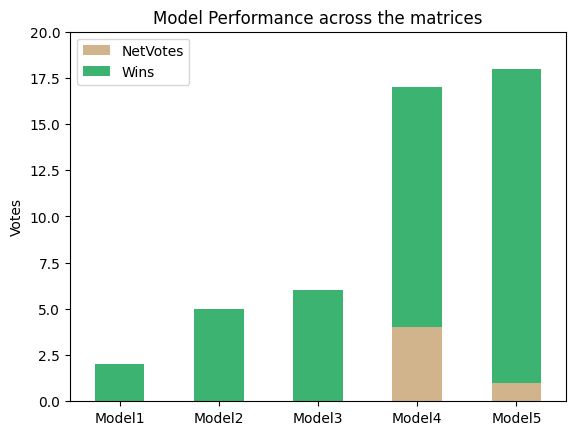

In [125]:
data = data[['NetVotes', 'Wins']].sort_values('Wins')
data.plot(kind='bar', stacked=True, color=['tan', 'mediumseagreen'])

plt.ylabel('Votes')
plt.xticks(rotation=0, ha='center')
plt.title('Model Performance across the matrices')
plt.ylim(0, 20)

plt.show()

From here, we will test our 4 best candidate models.

In [ ]:
# Elitism was not used in any
df[df.index.get_level_values(level='Elitism')]

,,,,,,,,,Matrix1,Matrix2,Matrix3,Matrix4,Matrix5,Matrix6,Matrix7,Matrix8,Matrix9,Matrix10,Matrix11,Matrix12,Matrix13,Matrix14,Matrix15,Matrix16,Matrix17,Matrix18,Votes,Wins
Selector,Crossover,Mutator,Pop_Size,N_Gens,P_XO,P_M,Elitism,N_elites,,,,,,,,,,,,,,,,,,,,


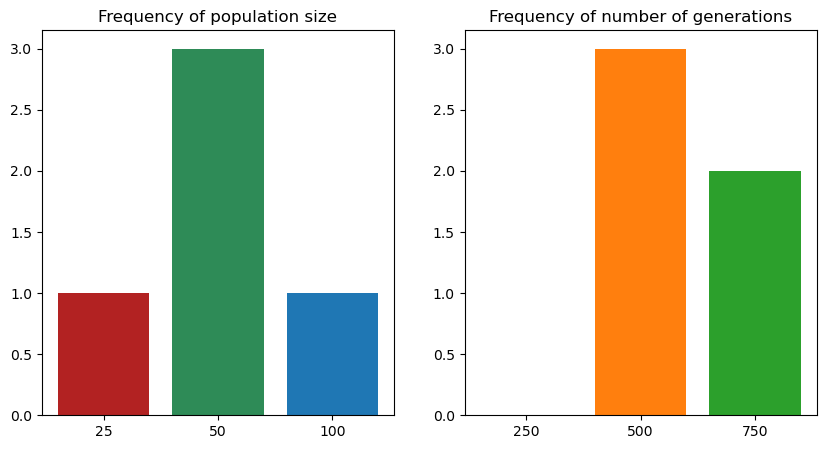

In [ ]:
pop_25 = df[df.index.get_level_values(level='Pop_Size') == 25]['Votes'].count()
pop_50 = df[df.index.get_level_values(level='Pop_Size') == 50]['Votes'].count()
pop_100 = df[df.index.get_level_values(level='Pop_Size') == 100]['Votes'].count()

gens_250 = df[df.index.get_level_values(level='N_Gens') == 250]['Votes'].count()
gens_500 = df[df.index.get_level_values(level='N_Gens') == 500]['Votes'].count()
gens_750 = df[df.index.get_level_values(level='N_Gens') == 750]['Votes'].count()


fig, axs = plt.subplots(1,2, figsize=(10,5) )

axs[0].bar('25', pop_25, color='firebrick')
axs[0].bar('50', pop_50, color='seagreen')
axs[0].bar('100', pop_100)
axs[0].set_title('Frequency of population size')

axs[1].bar('250', gens_250)
axs[1].bar('500', gens_500)
axs[1].bar('750', gens_750)
axs[1].set_title('Frequency of number of generations')

plt.show()

## Testing the candidate models

In [ ]:
# Creating a replacement dict to replace the name of the functions, by the functions, to be able to input their paramaters in GA()
rep_dict = {'ranking_selection': ranking_selection, 'roulette_wheel':roulette_wheel, 'tournament_sec2':tournament_selection(2),
            'tournament_sec5':tournament_selection(5), 'tournament_sec10':tournament_selection(10), 'two_point_xover':two_point_xover,
            'ox':ordered_xover, 'pmx_xover':pmx_xover, 'cyclic_xover':cyclic_xover, 'mm':mix_mutation,
            'swap_mutation':swap_mutation, 'inversion_mutation':inversion_mutation, 'dm':disp_mutation, 'tpm':two_point_mutation}

In [ ]:
# Creating a copy of our df with the function instead of their names
df_funcs = df.copy()
new_index = df_funcs.index.map(lambda x: tuple(rep_dict.get(item, item) for item in x))
df_funcs.index = new_index
df_funcs

,,,,,,,,,Matrix1,Matrix2,Matrix3,Matrix4,Matrix5,Matrix6,Matrix7,Matrix8,Matrix9,Matrix10,Matrix11,Matrix12,Matrix13,Matrix14,Matrix15,Matrix16,Matrix17,Matrix18,Votes,Wins
Selector,Crossover,Mutator,Pop_Size,N_Gens,P_XO,P_M,Elitism,N_elites,,,,,,,,,,,,,,,,,,,,
<function tournament_selection.<locals>.tournament_sec at 0x7ff3be027490>,<function pmx_xover at 0x7ff3bee5aa70>,<function inversion_mutation at 0x7ff3bee2eef0>,50,750,0.4,0.2,False,3,None,None,None,763.0,None,None,None,46869.0,None,None,None,None,None,None,None,None,None,None,2,2
<function tournament_selection.<locals>.tournament_sec at 0x7ff3bde35a20>,<function pmx_xover at 0x7ff3bee5aa70>,<function inversion_mutation at 0x7ff3bee2eef0>,50,500,0.4,0.4,False,5,87.0,533.0,None,761.0,5766.67,7369.0,7959.0,46856.0,72044.0,62929.0,516715.0,725468.0,731619.0,5076198.0,7280064.0,7344888.0,52302596.0,73352515.0,17,13
<function tournament_selection.<locals>.tournament_sec at 0x7ff3be027490>,<function two_point_xover at 0x7ff3bee2df30>,<function swap_mutation at 0x7ff3bee2f010>,50,750,0.4,0.2,False,3,None,None,None,763.0,5783.0,7369.0,None,None,None,None,None,725468.0,731619.0,5076198.0,None,None,None,None,6,6
<function ranking_selection at 0x7ff3bee59360>,<function cyclic_xover at 0x7ff3bee5a3b0>,<function inversion_mutation at 0x7ff3bee2eef0>,100,500,0.8,0.4,False,3,87.0,533.0,763.0,762.2,5783.0,7369.0,7959.0,46869.0,72044.0,62919.0,516715.0,725468.0,731619.0,5076198.0,7280064.0,7344888.0,52552794.0,73352515.0,18,16
<function tournament_selection.<locals>.tournament_sec at 0x7ff3bde35a20>,<function two_point_xover at 0x7ff3bee2df30>,<function swap_mutation at 0x7ff3bee2f010>,25,500,0.8,0.2,False,3,None,None,None,None,None,7369.0,None,None,None,62929.0,None,None,None,5076198.0,None,None,52552794.0,73352515.0,5,5


In [ ]:
df

,,,,,,,,,Matrix1,Matrix2,Matrix3,Matrix4,Matrix5,Matrix6,Matrix7,Matrix8,Matrix9,Matrix10,Matrix11,Matrix12,Matrix13,Matrix14,Matrix15,Matrix16,Matrix17,Matrix18,Votes,Wins
Selector,Crossover,Mutator,Pop_Size,N_Gens,P_XO,P_M,Elitism,N_elites,,,,,,,,,,,,,,,,,,,,
tournament_sec5,pmx_xover,inversion_mutation,50,750,0.4,0.2,False,3,None,None,None,763.0,None,None,None,46869.0,None,None,None,None,None,None,None,None,None,None,2,2
tournament_sec10,pmx_xover,inversion_mutation,50,500,0.4,0.4,False,5,87.0,533.0,None,761.0,5766.67,7369.0,7959.0,46856.0,72044.0,62929.0,516715.0,725468.0,731619.0,5076198.0,7280064.0,7344888.0,52302596.0,73352515.0,17,13
tournament_sec5,two_point_xover,swap_mutation,50,750,0.4,0.2,False,3,None,None,None,763.0,5783.0,7369.0,None,None,None,None,None,725468.0,731619.0,5076198.0,None,None,None,None,6,6
ranking_selection,cyclic_xover,inversion_mutation,100,500,0.8,0.4,False,3,87.0,533.0,763.0,762.2,5783.0,7369.0,7959.0,46869.0,72044.0,62919.0,516715.0,725468.0,731619.0,5076198.0,7280064.0,7344888.0,52552794.0,73352515.0,18,16
tournament_sec10,two_point_xover,swap_mutation,25,500,0.8,0.2,False,3,None,None,None,None,None,7369.0,None,None,None,62929.0,None,None,None,5076198.0,None,None,52552794.0,73352515.0,5,5


Testing our pre-chosen models to every matrix:

In [ ]:
results_geral = {}
# Iterating over every matrix
for i, mat in zip(trange(18), matrix):
    results_mat = []
    # And over every combination on best_models
    for func_index, str_index in zip(df_funcs.index, df.index):
        selector_func = func_index[0]
        crossover_func = func_index[1]
        mutator_func = func_index[2]

        selector = str_index[0]
        crossover = str_index[1]
        mutator = str_index[2]

        pop_size = str_index[3]
        n_gens = str_index[4]
        p_xo = str_index[5]
        p_m = str_index[6]
        elitism = str_index[7]
        n_elites = str_index[8]

        params = [selector, crossover, mutator,
                  pop_size, n_gens, p_xo, p_m, elitism, n_elites]
        score_list = []
        # Testring every model 5 times, and taking the mean of their scores
        for _ in range(5):

            score = GA(mat, create_population, evaluate_pop, selector_func, crossover_func, mutator_func, get_n_elites(n_elites), pop_size,
                       n_gens, p_xo, p_m, elitism=elitism)

            score_list.append(max(score[1]))

        final_score = round(np.mean(score_list), 3)

        results_mat.append([params, final_score])

    results_geral[f'Matrix{i+1}'] = results_mat

100%|██████████| 18/18 [08:41<00:00, 28.96s/it]


In [131]:
# Results of our candidate models across the matrices
results_geral = {'Matrix1': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   77.4],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   58.6],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   85.6],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   60.2],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   73.6]],
 'Matrix2': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   488.2],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   445.6],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   518.2],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   409.8],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   489.8]],
 'Matrix3': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   702.8],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   638.4],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   746.0],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   686.0],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   741.6]],
 'Matrix4': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   745.8],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   576.4],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   733.8],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   445.4],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   750.4]],
 'Matrix5': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   5456.0],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   4253.2],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   5339.8],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   4176.2],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   4810.2]],
 'Matrix6': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   6923.8],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   6548.8],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   7059.2],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   6165.6],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   7116.4]],
 'Matrix7': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   7495.0],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   5538.8],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   7567.0],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   3549.4],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   7007.8]],
 'Matrix8': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   44346.4],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   38846.8],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   46432.6],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   39301.6],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   44085.2]],
 'Matrix9': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   65118.0],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   59435.8],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   68505.8],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   54220.0],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   67026.6]],
 'Matrix10': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   54832.8],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   44581.6],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   60913.0],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   40822.6],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   54329.6]],
 'Matrix11': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   479674.8],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   401506.6],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   510678.2],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   403128.6],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   504012.4]],
 'Matrix12': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   697742.2],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   629129.8],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   695839.0],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   587919.4],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   703757.8]],
 'Matrix13': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   635034.4],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   478391.2],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   686732.8],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   428062.2],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   637607.2]],
 'Matrix14': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   4775459.8],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   4117705.6],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   4928387.4],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   3986815.2],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   4858322.4]],
 'Matrix15': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   6864879.4],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   5911232.0],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   7195034.8],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   6627719.4],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   7093473.6]],
 'Matrix16': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   6189421.6],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   4173697.0],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   7344888.0],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   3937254.6],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   6717785.2]],
 'Matrix17': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   50394243.8],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   43816079.4],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   51392290.0],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   43770182.4],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   50643960.0]],
 'Matrix18': [[['tournament_sec5',
    'two_point_xover',
    'swap_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   69402902.8],
  [['tournament_sec10',
    'pmx_xover',
    'inversion_mutation',
    50,
    500,
    0.4,
    0.4,
    False,
    5],
   58689493.0],
  [['tournament_sec10',
    'two_point_xover',
    'swap_mutation',
    25,
    500,
    0.8,
    0.2,
    False,
    3],
   68240519.6],
  [['ranking_selection',
    'cyclic_xover',
    'inversion_mutation',
    100,
    500,
    0.8,
    0.4,
    False,
    3],
   54787677.4],
  [['tournament_sec5',
    'pmx_xover',
    'inversion_mutation',
    50,
    750,
    0.4,
    0.2,
    False,
    3],
   68956928.4]]}

Transforming our results into a dataframe:

In [132]:
unique_param_combinations = set()
for mat in results_geral.values():
    for parameters, _ in mat:
        param_tuple = tuple(parameters)
        unique_param_combinations.add(tuple(param_tuple))

# creating the multiindex of our dataframe
index = pd.MultiIndex.from_tuples(unique_param_combinations, names=['Selector', 'Crossover', 'Mutator', 'Pop_Size', 'N_Gens', 'P_XO', 'P_M', 'Elitism', 'N_elites'])

scores = pd.DataFrame(index=index, columns=df.drop(['Votes', 'Wins'], axis=1).columns)

# iterating over the results
for matrix_name, mat in results_geral.items():
    for parameters, fitness in mat:
        param_tuple = tuple(parameters)
        scores.at[param_tuple, matrix_name] = fitness

scores

Matrix1  \
Selector          Crossover       Mutator            Pop_Size N_Gens P_XO P_M Elitism N_elites           
tournament_sec5   pmx_xover       inversion_mutation 50       750    0.4  0.2 False   3           73.6   
ranking_selection cyclic_xover    inversion_mutation 100      500    0.8  0.4 False   3           60.2   
tournament_sec10  pmx_xover       inversion_mutation 50       500    0.4  0.4 False   5           58.6   
                  two_point_xover swap_mutation      25       500    0.8  0.2 False   3           85.6   
tournament_sec5   two_point_xover swap_mutation      50       750    0.4  0.2 False   3           77.4   

                                                                                               Matrix2  \
Selector          Crossover       Mutator            Pop_Size N_Gens P_XO P_M Elitism N_elites           
tournament_sec5   pmx_xover       inversion_mutation 50       750    0.4  0.2 False   3          489.8   
ranking_selection cyclic_xover    inversion_mutation 100      500    0.8  0.4 False   3          409.8   
tournament_sec10  pmx_xover       inversion_mutation 50       500    0.4  0.4 False   5          445.6   
                  two_point_xover swap_mutation      25       500    0.8  0.2 False   3          518.2   
tournament_sec5   two_point_xover swap_mutation      50       750    0.4  0.2 False   3          488.2   

                                                                                               Matrix3  \
Selector          Crossover       Mutator            Pop_Size N_Gens P_XO P_M Elitism N_elites           
tournament_sec5   pmx_xover       inversion_mutation 50       750    0.4  0.2 False   3          741.6   
ranking_selection cyclic_xover    inversion_mutation 100      500    0.8  0.4 False   3          686.0   
tournament_sec10  pmx_xover       inversion_mutation 50       500    0.4  0.4 False   5          638.4   
                  two_point_xover swap_mutation      25       500    0.8  0.2 False   3          746.0   
tournament_sec5   two_point_xover swap_mutation      50       750    0.4  0.2 False   3          702.8   

                                                                                               Matrix4  \
Selector          Crossover       Mutator            Pop_Size N_Gens P_XO P_M Elitism N_elites           
tournament_sec5   pmx_xover       inversion_mutation 50       750    0.4  0.2 False   3          750.4   
ranking_selection cyclic_xover    inversion_mutation 100      500    0.8  0.4 False   3          445.4   
tournament_sec10  pmx_xover       inversion_mutation 50       500    0.4  0.4 False   5          576.4   
                  two_point_xover swap_mutation      25       500    0.8  0.2 False   3          733.8   
tournament_sec5   two_point_xover swap_mutation      50       750    0.4  0.2 False   3          745.8   

                                                                                               Matrix5  \
Selector          Crossover       Mutator            Pop_Size N_Gens P_XO P_M Elitism N_elites           
tournament_sec5   pmx_xover       inversion_mutation 50       750    0.4  0.2 False   3         4810.2   
ranking_selection cyclic_xover    inversion_mutation 100      500    0.8  0.4 False   3         4176.2   
tournament_sec10  pmx_xover       inversion_mutation 50       500    0.4  0.4 False   5         4253.2   
                  two_point_xover swap_mutation      25       500    0.8  0.2 False   3         5339.8   
tournament_sec5   two_point_xover swap_mutation      50       750    0.4  0.2 False   3         5456.0   

                                                                                               Matrix6  \
Selector          Crossover       Mutator            Pop_Size N_Gens P_XO P_M Elitism N_elites           
tournament_sec5   pmx_xover       inversion_mutation 50       750    0.4  0.2 False   3         7116.4   
ranking_selection cyclic_xover    inversion_mutation 100      

Getting the wins column:

In [134]:
max_indices = pd.DataFrame(index=scores.columns, columns=['Max_Indices'])

# Iterate over each column
for column in scores.columns:
    # Find the maximum value in the column
    max_val = scores[column].max()
    # Find all indices where the maximum value occurs
    indices = scores[scores[column] == max_val].index.tolist()
    # Store the indices in the 'Max_Indices' column
    max_indices.at[column, 'Max_Indices'] = indices

winners = dict(max_indices.explode('Max_Indices').value_counts())
winners = {key[0]:val for key, val in winners.items()}
scores['Wins'] = winners
scores['Wins'].fillna(0, inplace=True)
scores.loc[:,scores.columns.isin(['Wins'])]

Wins
Selector          Crossover       Mutator            Pop_Size N_Gens P_XO P_M Elitism N_elites      
tournament_sec5   pmx_xover       inversion_mutation 50       750    0.4  0.2 False   3          3.0
ranking_selection cyclic_xover    inversion_mutation 100      500    0.8  0.4 False   3          0.0
tournament_sec10  pmx_xover       inversion_mutation 50       500    0.4  0.4 False   5          0.0
                  two_point_xover swap_mutation      25       500    0.8  0.2 False   3         13.0
tournament_sec5   two_point_xover swap_mutation      50       750    0.4  0.2 False   3          2.0

Text(0.5, 1.0, 'Number of wins across the 18 matrices of each model')

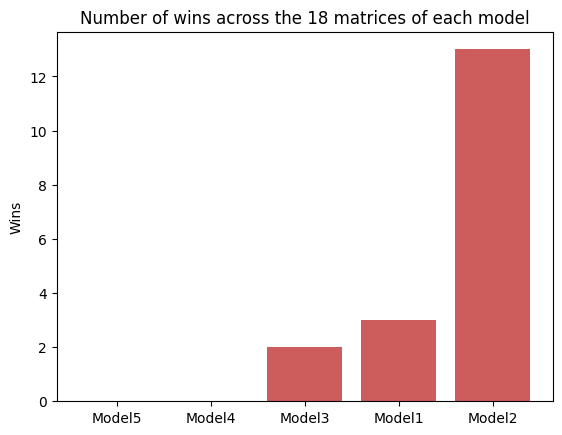

In [135]:
data = scores['Wins'].sort_values(ascending=True)
data.index = [ model_labels[data.index[i]] for i in range(len(data)) ]
plt.bar(data.index, data, color='indianred')
plt.ylabel('Wins')
plt.title('Number of wins across the 18 matrices of each model')

Creating other performance measures (ranking, mean and median)

In [129]:
scores_ranked = scores.rank()
scores_ranked['Mean'] = scores_ranked.mean(axis=1)
scores_ranked['Median'] = scores_ranked.median(axis=1)
scores_ranked.loc[:,scores_ranked.columns.isin(['Wins', 'Mean', 'Median'])].sort_values('Wins', ascending=False)

Wins  \
Selector          Crossover       Mutator            Pop_Size N_Gens P_XO P_M Elitism N_elites         
tournament_sec10  two_point_xover swap_mutation      25       500    0.8  0.2 False   3          5.0   
tournament_sec5   pmx_xover       inversion_mutation 50       750    0.4  0.2 False   3          4.0   
                  two_point_xover swap_mutation      50       750    0.4  0.2 False   3          3.0   
ranking_selection cyclic_xover    inversion_mutation 100      500    0.8  0.4 False   3          1.5   
tournament_sec10  pmx_xover       inversion_mutation 50       500    0.4  0.4 False   5          1.5   

                                                                                                    Mean  \
Selector          Crossover       Mutator            Pop_Size N_Gens P_XO P_M Elitism N_elites             
tournament_sec10  two_point_xover swap_mutation      25       500    0.8  0.2 False   3         4.578947   
tournament_sec5   pmx_xover       inversion_mutation 50       750    0.4  0.2 False   3         3.894737   
                  two_point_xover swap_mutation      50       750    0.4  0.2 False   3         3.526316   
ranking_selection cyclic_xover    inversion_mutation 100      500    0.8  0.4 False   3         1.289474   
tournament_sec10  pmx_xover       inversion_mutation 50       500    0.4  0.4 False   5         1.710526   

                                                                                                Median  
Selector          Crossover       Mutator            Pop_Size N_Gens P_XO P_M Elitism N_elites          
tournament_sec10  two_point_xover swap_mutation      25       500    0.8  0.2 False   3            5.0  
tournament_sec5   pmx_xover       inversion_mutation 50       750    0.4  0.2 False   3            4.0  
                  two_point_xover swap_mutation      50       750    0.4  0.2 False   3            3.0  
ranking_selection cyclic_xover    inversion_mutation 100      500    0.8  0.4 False   3            1.0  
tournament_sec10  pmx_xover       inversion_mutation 50       500    0.4  0.4 False   5            2.0

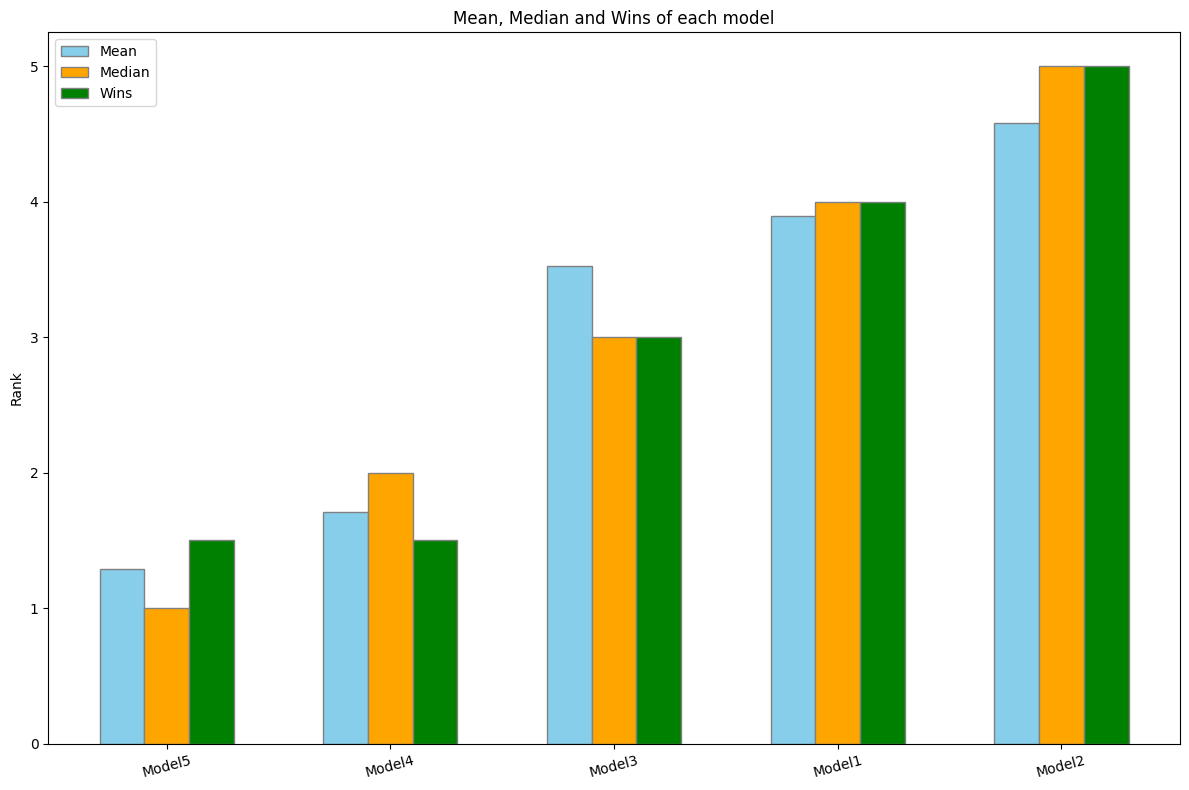

In [130]:
sorted_df = scores_ranked.sort_values(['Wins', 'Median', 'Mean'], ascending=True)
sorted_df.index = [ model_labels[sorted_df.index[i]] for i in range(len(sorted_df)) ]
labels = sorted_df.index
means = list(sorted_df['Mean'])
medians = list(sorted_df['Median'])
wins = list(sorted_df['Wins'])

bar_width = 0.2

r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(12, 8))

plt.bar(r1, means, color='skyblue', width=bar_width, edgecolor='grey', label='Mean')
plt.bar(r2, medians, color='orange', width=bar_width, edgecolor='grey', label='Median')
plt.bar(r3, wins, color='green', width=bar_width, edgecolor='grey', label='Wins')

plt.ylabel('Rank')
plt.title('Mean, Median and Wins of each model')
plt.xticks([r + bar_width for r in range(len(labels))], labels, rotation=15, ha='center')
plt.legend()
plt.tight_layout()

plt.show()

In [136]:
best_model = [key for key, val in model_labels.items() if val == 'Model2'][0]
best_model

('tournament_sec10',
 'two_point_xover',
 'swap_mutation',
 25,
 500,
 0.8,
 0.2,
 False,
 3)

In [ ]:
result = GA(matrix= # input data here,
                initializer=create_population,
                evaluator=evaluate_pop,
                selector=tournament_selection(10),
                crossover=two_point_xover,
                mutator=swap_mutation,
                elite_func=get_n_elites(3),
                pop_size=25,
                n_gens=500,
                p_xo=0.8,
                p_m=0.2,
                elitism=False)